In [2]:
import sys
import time
import math
sys.path.insert(0, r'/home/danis/work/python_works/gamma_4/Scripts')
sys.path.insert(0, r'D:\Учеба\Практика\Диплом\gamma_4\Scripts')
import numpy as np
import pandas as pd
from materials import*
import matplotlib.pyplot as plt

Минимальная энергия: 1e-3
windows (w) or linux (l): l


Параметры пучков и спектры

In [4]:
linspace1 = np.linspace(0.035, 0.1, 25, dtype=np.float32)
linspace2 = np.geomspace(0.11, 3, 25, dtype=np.float32)

beams_energyes = []
beams_energyes.extend(linspace1)
beams_energyes.extend(linspace2)

In [13]:
m = 60
target = R(Material(m), 0.01)

brems = [target.brem(beams_energy) for beams_energy in beams_energyes]
brems_e = [brem * en for brem in brems]

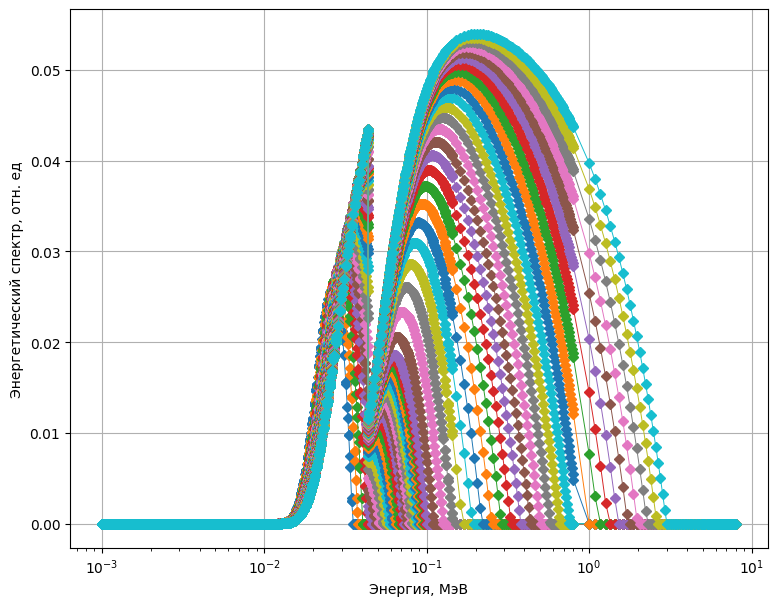

In [14]:
fig, ax = plt.subplots(figsize=(9, 7))

for br in brems_e:
    ax.plot(en, br, ls='-', marker='D', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)

ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1e-3, 0.1e0)
# ax.set_ylim(1e-7, 1.2)

ax.grid(True)

# fig.savefig('Тормозной спектр.jpg', bbox_inches='tight')

Номер первого канала и К-скачки

In [15]:
n = 11

In [16]:
# Индексы К скачков
EDGE = []
for i in range(1, len(en)):
    if en[i - 1] == en[i]:
        EDGE.append(i - 1)

In [17]:
EDGE.remove(EDGE[EDGE.index(Material(m).k_index())])

Уровни пропускания в К-крае

In [18]:
linspace3 = np.linspace(0.001, 0.9, 101)
for i, val in enumerate(linspace3):
    linspace3[i] = round(val, 5)
    
edge_max_values = []
edge_max_values.extend(linspace3)

Спектральные характеристики чувствительности каналов

In [19]:
edge_thiknesses = [[Material(i).lt(j) for i in range(n, 101)] for j in edge_max_values]

In [20]:
edge_regions = [[R(Material(i+n), edge_thiknesses[j][i]) for i in range(0, len(edge_thiknesses[j]))] for j in range(len(edge_thiknesses))]
resp_edges = [[val.f() for val in edge_regions[j]] for j in range(len(edge_regions))]

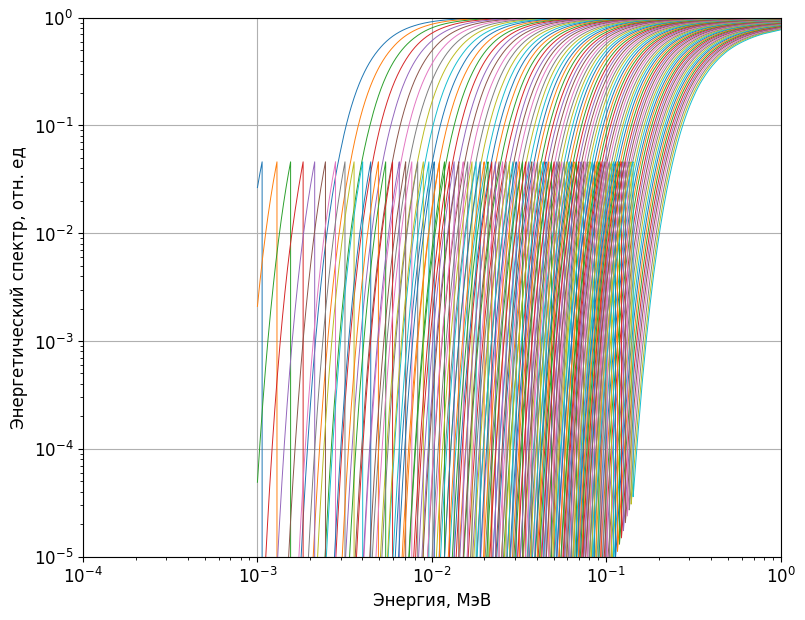

In [21]:
fig, ax = plt.subplots(figsize=(9, 7))

for i in resp_edges[5]:
    ax.plot(en, i, ls='-', lw='0.7', ms=5)

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=12)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=12)
ax.tick_params(axis='both', labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1e-4, 1e0)
ax.set_ylim(1e-5, 1e0)
ax.grid(True)

Матрицы задач

In [22]:
from garipov_deconvolution import get_coeff_simpson

In [23]:
Matrixs = []

start_time = time.time()

for i in range(len(resp_edges)):
    print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
    matrix = []
    
    for response in resp_edges[i]:
        matrix.append(get_coeff_simpson(response, en, EDGE)[0])
    
    Matrixs.append(matrix)

(0), время: 0.00063 секунд
(1), время: 2.64346 секунд
(2), время: 5.22644 секунд
(3), время: 7.76813 секунд
(4), время: 10.30392 секунд
(5), время: 12.86166 секунд
(6), время: 15.41811 секунд
(7), время: 17.98342 секунд
(8), время: 20.55065 секунд
(9), время: 23.11768 секунд
(10), время: 25.69227 секунд
(11), время: 28.23861 секунд
(12), время: 30.80278 секунд
(13), время: 33.3594 секунд
(14), время: 35.92525 секунд
(15), время: 38.49779 секунд
(16), время: 41.06417 секунд
(17), время: 43.61963 секунд
(18), время: 46.18816 секунд
(19), время: 48.76686 секунд
(20), время: 51.32974 секунд
(21), время: 53.90668 секунд
(22), время: 56.4754 секунд
(23), время: 59.04065 секунд
(24), время: 61.59518 секунд
(25), время: 64.16676 секунд
(26), время: 66.73589 секунд
(27), время: 69.36635 секунд
(28), время: 72.02535 секунд
(29), время: 74.65857 секунд
(30), время: 77.24809 секунд
(31), время: 79.86114 секунд
(32), время: 82.44324 секунд
(33), время: 85.14226 секунд
(34), время: 88.00597 секунд
(

Сигналы измерительных каналов

In [24]:
new_en = get_coeff_simpson(resp_edges[0][0], en, EDGE)[1]

In [25]:
def signals_from_one_spectrum(spectrum):
    
    start_time = time.time()
    signals_simpson = []
    
    # для каждой матрицы
    for i, matrix in enumerate(Matrixs):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        
        # сигналы для каждой задачи
        signals = []
        
        # для каждой строки в матрице
        for row in matrix:
            # значение одного сигнала
            signal = sum(row * np.interp(new_en, en, spectrum))
            signals.append(signal)
            
        signals_simpson.append(signals)
        
    return signals_simpson

Сигналы для каждого спектра

In [26]:
spectrums_signals = []

for spectrum in brems_e:
    spectrums_signals.append(signals_from_one_spectrum(spectrum))

(0), время: 0.0 секунд
(1), время: 0.0592 секунд
(2), время: 0.11731 секунд
(3), время: 0.17615 секунд
(4), время: 0.23567 секунд
(5), время: 0.29405 секунд
(6), время: 0.35262 секунд
(7), время: 0.41104 секунд
(8), время: 0.47018 секунд
(9), время: 0.52863 секунд
(10), время: 0.5869 секунд
(11), время: 0.64548 секунд
(12), время: 0.70483 секунд
(13), время: 0.7634 секунд
(14), время: 0.82181 секунд
(15), время: 0.88039 секунд
(16), время: 0.93972 секунд
(17), время: 0.9748 секунд
(18), время: 1.00256 секунд
(19), время: 1.03083 секунд
(20), время: 1.05901 секунд
(21), время: 1.08712 секунд
(22), время: 1.11528 секунд
(23), время: 1.1474 секунд
(24), время: 1.20586 секунд
(25), время: 1.26443 секунд
(26), время: 1.32344 секунд
(27), время: 1.38839 секунд
(28), время: 1.44802 секунд
(29), время: 1.5071 секунд
(30), время: 1.56623 секунд
(31), время: 1.62654 секунд
(32), время: 1.68493 секунд
(33), время: 1.74301 секунд
(34), время: 1.80296 секунд
(35), время: 1.86232 секунд
(36), время:

(99), время: 4.32084 секунд
(100), время: 4.34904 секунд
(0), время: 0.0 секунд
(1), время: 0.02829 секунд
(2), время: 0.05651 секунд
(3), время: 0.0844 секунд
(4), время: 0.11228 секунд
(5), время: 0.14019 секунд
(6), время: 0.17132 секунд
(7), время: 0.19952 секунд
(8), время: 0.22779 секунд
(9), время: 0.25606 секунд
(10), время: 0.28422 секунд
(11), время: 0.31232 секунд
(12), время: 0.34071 секунд
(13), время: 0.36889 секунд
(14), время: 0.39985 секунд
(15), время: 0.42804 секунд
(16), время: 0.45603 секунд
(17), время: 0.48417 секунд
(18), время: 0.51231 секунд
(19), время: 0.5404 секунд
(20), время: 0.56857 секунд
(21), время: 0.59668 секунд
(22), время: 0.62684 секунд
(23), время: 0.65545 секунд
(24), время: 0.68364 секунд
(25), время: 0.71175 секунд
(26), время: 0.73986 секунд
(27), время: 0.768 секунд
(28), время: 0.79614 секунд
(29), время: 0.82437 секунд
(30), время: 0.85567 секунд
(31), время: 0.88386 секунд
(32), время: 0.91307 секунд
(33), время: 0.94143 секунд
(34), вре

(94), время: 5.45218 секунд
(95), время: 5.51055 секунд
(96), время: 5.5686 секунд
(97), время: 5.62721 секунд
(98), время: 5.68658 секунд
(99), время: 5.74497 секунд
(100), время: 5.80297 секунд
(0), время: 1e-05 секунд
(1), время: 0.06002 секунд
(2), время: 0.1183 секунд
(3), время: 0.17673 секунд
(4), время: 0.23557 секунд
(5), время: 0.29478 секунд
(6), время: 0.3535 секунд
(7), время: 0.41196 секунд
(8), время: 0.47041 секунд
(9), время: 0.53001 секунд
(10), время: 0.58833 секунд
(11), время: 0.6463 секунд
(12), время: 0.70473 секунд
(13), время: 0.76455 секунд
(14), время: 0.82314 секунд
(15), время: 0.88203 секунд
(16), время: 0.94076 секунд
(17), время: 1.00016 секунд
(18), время: 1.05842 секунд
(19), время: 1.11649 секунд
(20), время: 1.17515 секунд
(21), время: 1.23468 секунд
(22), время: 1.29298 секунд
(23), время: 1.35094 секунд
(24), время: 1.40943 секунд
(25), время: 1.4685 секунд
(26), время: 1.52766 секунд
(27), время: 1.58635 секунд
(28), время: 1.64496 секунд
(29), вр

(88), время: 2.50289 секунд
(89), время: 2.53089 секунд
(90), время: 2.55883 секунд
(91), время: 2.58679 секунд
(92), время: 2.61472 секунд
(93), время: 2.64297 секунд
(94), время: 2.67094 секунд
(95), время: 2.69898 секунд
(96), время: 2.72939 секунд
(97), время: 2.75746 секунд
(98), время: 2.78515 секунд
(99), время: 2.81311 секунд
(100), время: 2.84102 секунд
(0), время: 0.0 секунд
(1), время: 0.02813 секунд
(2), время: 0.05586 секунд
(3), время: 0.08643 секунд
(4), время: 0.11441 секунд
(5), время: 0.14213 секунд
(6), время: 0.17014 секунд
(7), время: 0.19817 секунд
(8), время: 0.22626 секунд
(9), время: 0.25422 секунд
(10), время: 0.28268 секунд
(11), время: 0.31294 секунд
(12), время: 0.34118 секунд
(13), время: 0.36914 секунд
(14), время: 0.39715 секунд
(15), время: 0.42552 секунд
(16), время: 0.45351 секунд
(17), время: 0.48146 секунд
(18), время: 0.50949 секунд
(19), время: 0.54037 секунд
(20), время: 0.56857 секунд
(21), время: 0.59632 секунд
(22), время: 0.62429 секунд
(23),

(87), время: 2.47495 секунд
(88), время: 2.50291 секунд
(89), время: 2.5306 секунд
(90), время: 2.55897 секунд
(91), время: 2.60348 секунд
(92), время: 2.66152 секунд
(93), время: 2.72181 секунд
(94), время: 2.77964 секунд
(95), время: 2.83883 секунд
(96), время: 2.89694 секунд
(97), время: 2.95595 секунд
(98), время: 3.01546 секунд
(99), время: 3.07372 секунд
(100), время: 3.13202 секунд
(0), время: 1e-05 секунд
(1), время: 0.05785 секунд
(2), время: 0.11542 секунд
(3), время: 0.17371 секунд
(4), время: 0.23272 секунд
(5), время: 0.29057 секунд
(6), время: 0.34883 секунд
(7), время: 0.40716 секунд
(8), время: 0.46625 секунд
(9), время: 0.52471 секунд
(10), время: 0.583 секунд
(11), время: 0.64131 секунд
(12), время: 0.7003 секунд
(13), время: 0.75815 секунд
(14), время: 0.81573 секунд
(15), время: 0.87409 секунд
(16), время: 0.93327 секунд
(17), время: 0.99111 секунд
(18), время: 1.04866 секунд
(19), время: 1.10701 секунд
(20), время: 1.16603 секунд
(21), время: 1.2239 секунд
(22), вр

(80), время: 2.46618 секунд
(81), время: 2.52379 секунд
(82), время: 2.58108 секунд
(83), время: 2.63941 секунд
(84), время: 2.69864 секунд
(85), время: 2.75627 секунд
(86), время: 2.81357 секунд
(87), время: 2.87196 секунд
(88), время: 2.9312 секунд
(89), время: 2.98888 секунд
(90), время: 3.04653 секунд
(91), время: 3.10485 секунд
(92), время: 3.16403 секунд
(93), время: 3.22163 секунд
(94), время: 3.27894 секунд
(95), время: 3.33739 секунд
(96), время: 3.39671 секунд
(97), время: 3.45435 секунд
(98), время: 3.51165 секунд
(99), время: 3.56998 секунд
(100), время: 3.62897 секунд
(0), время: 1e-05 секунд
(1), время: 0.05807 секунд
(2), время: 0.11617 секунд
(3), время: 0.1751 секунд
(4), время: 0.2327 секунд
(5), время: 0.29005 секунд
(6), время: 0.34811 секунд
(7), время: 0.40718 секунд
(8), время: 0.46478 секунд
(9), время: 0.52206 секунд
(10), время: 0.58038 секунд
(11), время: 0.63938 секунд
(12), время: 0.6976 секунд
(13), время: 0.75561 секунд
(14), время: 0.8136 секунд
(15), вр

(77), время: 2.19676 секунд
(78), время: 2.22515 секунд
(79), время: 2.25306 секунд
(80), время: 2.28118 секунд
(81), время: 2.30933 секунд
(82), время: 2.33761 секунд
(83), время: 2.36604 секунд
(84), время: 2.39417 секунд
(85), время: 2.42527 секунд
(86), время: 2.45341 секунд
(87), время: 2.48135 секунд
(88), время: 2.50948 секунд
(89), время: 2.5376 секунд
(90), время: 2.56566 секунд
(91), время: 2.59396 секунд
(92), время: 2.6221 секунд
(93), время: 2.6524 секунд
(94), время: 2.68063 секунд
(95), время: 2.70854 секунд
(96), время: 2.73669 секунд
(97), время: 2.76474 секунд
(98), время: 2.79281 секунд
(99), время: 2.82106 секунд
(100), время: 2.84922 секунд
(0), время: 0.0 секунд
(1), время: 0.02828 секунд
(2), время: 0.05627 секунд
(3), время: 0.0844 секунд
(4), время: 0.11252 секунд
(5), время: 0.14074 секунд
(6), время: 0.16887 секунд
(7), время: 0.19732 секунд
(8), время: 0.22764 секунд
(9), время: 0.2559 секунд
(10), время: 0.28397 секунд
(11), время: 0.31219 секунд
(12), врем

(76), время: 2.38846 секунд
(77), время: 2.41706 секунд
(78), время: 2.44504 секунд
(79), время: 2.47385 секунд
(80), время: 2.50195 секунд
(81), время: 2.53007 секунд
(82), время: 2.55839 секунд
(83), время: 2.58648 секунд
(84), время: 2.61704 секунд
(85), время: 2.64541 секунд
(86), время: 2.67373 секунд
(87), время: 2.70187 секунд
(88), время: 2.72997 секунд
(89), время: 2.75814 секунд
(90), время: 2.78628 секунд
(91), время: 2.81439 секунд
(92), время: 2.8449 секунд
(93), время: 2.87301 секунд
(94), время: 2.90103 секунд
(95), время: 2.92926 секунд
(96), время: 2.95735 секунд
(97), время: 2.98544 секунд
(98), время: 3.01359 секунд
(99), время: 3.04169 секунд
(100), время: 3.07208 секунд
(0), время: 0.0 секунд
(1), время: 0.02809 секунд
(2), время: 0.05647 секунд
(3), время: 0.08458 секунд
(4), время: 0.11269 секунд
(5), время: 0.14081 секунд
(6), время: 0.16902 секунд
(7), время: 0.19936 секунд
(8), время: 0.22755 секунд
(9), время: 0.25559 секунд
(10), время: 0.28363 секунд
(11), 

(71), время: 2.40851 секунд
(72), время: 2.46684 секунд
(73), время: 2.52491 секунд
(74), время: 2.58338 секунд
(75), время: 2.64258 секунд
(76), время: 2.70101 секунд
(77), время: 2.75965 секунд
(78), время: 2.81824 секунд
(79), время: 2.87748 секунд
(80), время: 2.93574 секунд
(81), время: 2.99369 секунд
(82), время: 3.05231 секунд
(83), время: 3.11154 секунд
(84), время: 3.16983 секунд
(85), время: 3.22784 секунд
(86), время: 3.28624 секунд
(87), время: 3.3455 секунд
(88), время: 3.40433 секунд
(89), время: 3.46299 секунд
(90), время: 3.52157 секунд
(91), время: 3.58083 секунд
(92), время: 3.63905 секунд
(93), время: 3.69713 секунд
(94), время: 3.75571 секунд
(95), время: 3.81488 секунд
(96), время: 3.87314 секунд
(97), время: 3.9311 секунд
(98), время: 3.98957 секунд
(99), время: 4.04878 секунд
(100), время: 4.10705 секунд
(0), время: 0.0 секунд
(1), время: 0.05864 секунд
(2), время: 0.11769 секунд
(3), время: 0.17595 секунд
(4), время: 0.23447 секунд
(5), время: 0.29303 секунд
(6)

(64), время: 3.79569 секунд
(65), время: 3.85353 секунд
(66), время: 3.9111 секунд
(67), время: 3.96941 секунд
(68), время: 4.02854 секунд
(69), время: 4.0865 секунд
(70), время: 4.14416 секунд
(71), время: 4.20261 секунд
(72), время: 4.26163 секунд
(73), время: 4.31946 секунд
(74), время: 4.37767 секунд
(75), время: 4.43605 секунд
(76), время: 4.49508 секунд
(77), время: 4.55314 секунд
(78), время: 4.6108 секунд
(79), время: 4.66917 секунд
(80), время: 4.72828 секунд
(81), время: 4.78612 секунд
(82), время: 4.84367 секунд
(83), время: 4.90197 секунд
(84), время: 4.96098 секунд
(85), время: 5.01925 секунд
(86), время: 5.07754 секунд
(87), время: 5.13594 секунд
(88), время: 5.19503 секунд
(89), время: 5.25293 секунд
(90), время: 5.31047 секунд
(91), время: 5.36901 секунд
(92), время: 5.42832 секунд
(93), время: 5.48667 секунд
(94), время: 5.54407 секунд
(95), время: 5.60268 секунд
(96), время: 5.66196 секунд
(97), время: 5.72039 секунд
(98), время: 5.77846 секунд
(99), время: 5.837 секу

(58), время: 1.71006 секунд
(59), время: 1.73823 секунд
(60), время: 1.76619 секунд
(61), время: 1.79429 секунд
(62), время: 1.8223 секунд
(63), время: 1.85029 секунд
(64), время: 1.87823 секунд
(65), время: 1.90622 секунд
(66), время: 1.93677 секунд
(67), время: 1.9648 секунд
(68), время: 1.99253 секунд
(69), время: 2.02055 секунд
(70), время: 2.04868 секунд
(71), время: 2.07663 секунд
(72), время: 2.10459 секунд
(73), время: 2.13256 секунд
(74), время: 2.16279 секунд
(75), время: 2.19079 секунд
(76), время: 2.21844 секунд
(77), время: 2.24654 секунд
(78), время: 2.27477 секунд
(79), время: 2.3029 секунд
(80), время: 2.33084 секунд
(81), время: 2.35876 секунд
(82), время: 2.38897 секунд
(83), время: 2.4169 секунд
(84), время: 2.44465 секунд
(85), время: 2.47255 секунд
(86), время: 2.50048 секунд
(87), время: 2.52849 секунд
(88), время: 2.55645 секунд
(89), время: 2.58435 секунд
(90), время: 2.61471 секунд
(91), время: 2.64289 секунд
(92), время: 2.67063 секунд
(93), время: 2.69864 сек

(57), время: 1.62307 секунд
(58), время: 1.65126 секунд
(59), время: 1.679 секунд
(60), время: 1.70701 секунд
(61), время: 1.73501 секунд
(62), время: 1.76294 секунд
(63), время: 1.79086 секунд
(64), время: 1.81886 секунд
(65), время: 1.84921 секунд
(66), время: 1.87721 секунд
(67), время: 1.90519 секунд
(68), время: 1.93321 секунд
(69), время: 1.96117 секунд
(70), время: 1.98913 секунд
(71), время: 2.01754 секунд
(72), время: 2.04551 секунд
(73), время: 2.07578 секунд
(74), время: 2.10387 секунд
(75), время: 2.13209 секунд
(76), время: 2.16005 секунд
(77), время: 2.18796 секунд
(78), время: 2.21595 секунд
(79), время: 2.24417 секунд
(80), время: 2.27351 секунд
(81), время: 2.30421 секунд
(82), время: 2.33228 секунд
(83), время: 2.36001 секунд
(84), время: 2.38861 секунд
(85), время: 2.41662 секунд
(86), время: 2.44457 секунд
(87), время: 2.47258 секунд
(88), время: 2.50056 секунд
(89), время: 2.53089 секунд
(90), время: 2.55899 секунд
(91), время: 2.5868 секунд
(92), время: 2.6148 сек

(49), время: 2.43191 секунд
(50), время: 2.4601 секунд
(51), время: 2.48796 секунд
(52), время: 2.51603 секунд
(53), время: 2.54414 секунд
(54), время: 2.57223 секунд
(55), время: 2.60032 секунд
(56), время: 2.62842 секунд
(57), время: 2.65905 секунд
(58), время: 2.6881 секунд
(59), время: 2.71605 секунд
(60), время: 2.74465 секунд
(61), время: 2.77323 секунд
(62), время: 2.80138 секунд
(63), время: 2.82947 секунд
(64), время: 2.85755 секунд
(65), время: 2.88936 секунд
(66), время: 2.91771 секунд
(67), время: 2.94639 секунд
(68), время: 2.97451 секунд
(69), время: 3.00266 секунд
(70), время: 3.03076 секунд
(71), время: 3.05886 секунд
(72), время: 3.087 секунд
(73), время: 3.11738 секунд
(74), время: 3.1455 секунд
(75), время: 3.17342 секунд
(76), время: 3.20153 секунд
(77), время: 3.22961 секунд
(78), время: 3.25766 секунд
(79), время: 3.28574 секунд
(80), время: 3.31406 секунд
(81), время: 3.34438 секунд
(82), время: 3.3725 секунд
(83), время: 3.40051 секунд
(84), время: 3.42861 секун

(49), время: 1.40219 секунд
(50), время: 1.45254 секунд
(51), время: 1.48045 секунд
(52), время: 1.50895 секунд
(53), время: 1.5371 секунд
(54), время: 1.5655 секунд
(55), время: 1.59364 секунд
(56), время: 1.63392 секунд
(57), время: 1.66216 секунд
(58), время: 1.69026 секунд
(59), время: 1.72639 секунд
(60), время: 1.75527 секунд
(61), время: 1.78337 секунд
(62), время: 1.81498 секунд
(63), время: 1.84537 секунд
(64), время: 1.87358 секунд
(65), время: 1.90144 секунд
(66), время: 1.92966 секунд
(67), время: 1.95784 секунд
(68), время: 1.98593 секунд
(69), время: 2.01404 секунд
(70), время: 2.04218 секунд
(71), время: 2.07249 секунд
(72), время: 2.10069 секунд
(73), время: 2.12872 секунд
(74), время: 2.15702 секунд
(75), время: 2.18513 секунд
(76), время: 2.21324 секунд
(77), время: 2.2503 секунд
(78), время: 2.29279 секунд
(79), время: 2.32103 секунд
(80), время: 2.34905 секунд
(81), время: 2.37723 секунд
(82), время: 2.40539 секунд
(83), время: 2.43449 секунд
(84), время: 2.46266 се

(43), время: 1.52541 секунд
(44), время: 1.5841 секунд
(45), время: 1.64224 секунд
(46), время: 1.701 секунд
(47), время: 1.76062 секунд
(48), время: 1.81906 секунд
(49), время: 1.87755 секунд
(50), время: 1.93631 секунд
(51), время: 1.99594 секунд
(52), время: 2.05432 секунд
(53), время: 2.11244 секунд
(54), время: 2.17126 секунд
(55), время: 2.23085 секунд
(56), время: 2.28928 секунд
(57), время: 2.34738 секунд
(58), время: 2.40612 секунд
(59), время: 2.46577 секунд
(60), время: 2.52436 секунд
(61), время: 2.58314 секунд
(62), время: 2.64185 секунд
(63), время: 2.70144 секунд
(64), время: 2.75982 секунд
(65), время: 2.81794 секунд
(66), время: 2.87671 секунд
(67), время: 2.93631 секунд
(68), время: 2.9947 секунд
(69), время: 3.05279 секунд
(70), время: 3.11154 секунд
(71), время: 3.17112 секунд
(72), время: 3.23008 секунд
(73), время: 3.28886 секунд
(74), время: 3.34759 секунд
(75), время: 3.40716 секунд
(76), время: 3.46555 секунд
(77), время: 3.52372 секунд
(78), время: 3.5617 секу

(36), время: 2.10239 секунд
(37), время: 2.16034 секунд
(38), время: 2.21825 секунд
(39), время: 2.27666 секунд
(40), время: 2.33576 секунд
(41), время: 2.39454 секунд
(42), время: 2.45325 секунд
(43), время: 2.51218 секунд
(44), время: 2.57151 секунд
(45), время: 2.63065 секунд
(46), время: 2.68893 секунд
(47), время: 2.74801 секунд
(48), время: 2.80735 секунд
(49), время: 2.86581 секунд
(50), время: 2.92405 секунд
(51), время: 2.98372 секунд
(52), время: 3.04336 секунд
(53), время: 3.102 секунд
(54), время: 3.16029 секунд
(55), время: 3.21951 секунд
(56), время: 3.27903 секунд
(57), время: 3.33757 секунд
(58), время: 3.39635 секунд
(59), время: 3.45522 секунд
(60), время: 3.51491 секунд
(61), время: 3.57344 секунд
(62), время: 3.63172 секунд
(63), время: 3.69039 секунд
(64), время: 3.75047 секунд
(65), время: 3.8087 секунд
(66), время: 3.86662 секунд
(67), время: 3.925 секунд
(68), время: 3.98495 секунд
(69), время: 4.04394 секунд
(70), время: 4.10303 секунд
(71), время: 4.1619 секун

(29), время: 1.69808 секунд
(30), время: 1.75605 секунд
(31), время: 1.81379 секунд
(32), время: 1.8722 секунд
(33), время: 1.93159 секунд
(34), время: 1.98959 секунд
(35), время: 2.04727 секунд
(36), время: 2.10573 секунд
(37), время: 2.16501 секунд
(38), время: 2.22355 секунд
(39), время: 2.28219 секунд
(40), время: 2.34064 секунд
(41), время: 2.39999 секунд
(42), время: 2.4586 секунд
(43), время: 2.51633 секунд
(44), время: 2.57476 секунд
(45), время: 2.63393 секунд
(46), время: 2.69205 секунд
(47), время: 2.74985 секунд
(48), время: 2.8083 секунд
(49), время: 2.86752 секунд
(50), время: 2.9258 секунд
(51), время: 2.98339 секунд
(52), время: 3.04187 секунд
(53), время: 3.10096 секунд
(54), время: 3.15892 секунд
(55), время: 3.21736 секунд
(56), время: 3.27584 секунд
(57), время: 3.33493 секунд
(58), время: 3.39289 секунд
(59), время: 3.45107 секунд
(60), время: 3.5094 секунд
(61), время: 3.56855 секунд
(62), время: 3.62645 секунд
(63), время: 3.6843 секунд
(64), время: 3.74271 секун

Восстановление спектров

In [27]:
from garipov_deconvolution import Gold

In [28]:
def deconvolution_one_spectrum(spectrum, signals_from_this_spectrum):
    
    sp = [0 for i in range(len(resp_edges))]
    dev = [0 for i in range(len(resp_edges))]
    norm = [0 for i in range(len(resp_edges))]
    
    start_time = time.time()
    
    for i in range(len(resp_edges)):
        print(f'({i}), время: {round(time.time() - start_time, 5)} секунд')
        sp[i], norm[i], dev[i] = Gold(Matrixs[i], signals_from_this_spectrum[i], en, spectrum, new_en, 1, 10000, w=True, d=False)[:3]
    return sp, dev

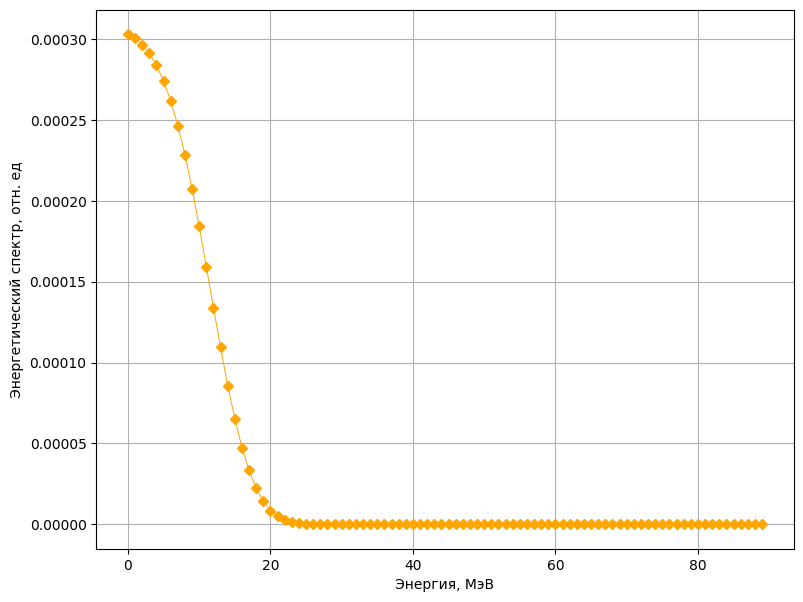

In [29]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(range(90), spectrums_signals[0][0], ls='-', marker='D', lw='0.7', ms=5, color='orange')

# настройки графика
ax.set_xlabel('Энергия, МэВ', fontsize=10)
ax.set_ylabel('Энергетический спектр, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlim(1.e-5, 0.3e-4)
# ax.set_ylim(1e-7, 1.2)
ax.grid(True)

Скрипт

In [30]:
SP, DEV = [], []

for j in range(len(brems_e)):
    sp, dev = deconvolution_one_spectrum(brems_e[j], spectrums_signals[j])
    SP.append(sp)
    DEV.append(dev)
    print(f'ВЫПОЛНЕНО {j+1} из {len(brems_e)}')

(0), время: 0.0 секунд
(1), время: 5.60109 секунд
(2), время: 10.67132 секунд
(3), время: 16.26254 секунд
(4), время: 20.8305 секунд
(5), время: 26.43943 секунд
(6), время: 31.82619 секунд
(7), время: 37.63119 секунд
(8), время: 43.27529 секунд
(9), время: 48.97737 секунд
(10), время: 53.83585 секунд
(11), время: 59.10333 секунд
(12), время: 64.22249 секунд
(13), время: 69.49508 секунд
(14), время: 74.25733 секунд
(15), время: 79.95264 секунд
(16), время: 85.81445 секунд
(17), время: 91.50425 секунд
(18), время: 97.32858 секунд
(19), время: 102.74808 секунд
(20), время: 109.2673 секунд
(21), время: 113.44044 секунд
(22), время: 117.41745 секунд
(23), время: 121.63621 секунд
(24), время: 127.95636 секунд
(25), время: 133.16567 секунд
(26), время: 139.78847 секунд
(27), время: 145.91558 секунд
(28), время: 150.15008 секунд
(29), время: 156.84441 секунд
(30), время: 162.13124 секунд
(31), время: 168.28344 секунд
(32), время: 174.95856 секунд
(33), время: 181.87242 секунд
(34), время: 186.

(75), время: 632.66403 секунд
(76), время: 640.90165 секунд
(77), время: 650.1509 секунд
(78), время: 658.61624 секунд
(79), время: 666.8287 секунд
(80), время: 674.4903 секунд
(81), время: 682.29038 секунд
(82), время: 690.60865 секунд
(83), время: 699.23795 секунд
(84), время: 707.50589 секунд
(85), время: 714.69926 секунд
(86), время: 722.2294 секунд
(87), время: 729.83228 секунд
(88), время: 737.48292 секунд
(89), время: 746.09167 секунд
(90), время: 754.4585 секунд
(91), время: 763.13546 секунд
(92), время: 771.32909 секунд
(93), время: 779.72628 секунд
(94), время: 788.2482 секунд
(95), время: 796.87964 секунд
(96), время: 805.52917 секунд
(97), время: 813.97795 секунд
(98), время: 822.42098 секунд
(99), время: 830.36541 секунд
(100), время: 837.66579 секунд
ВЫПОЛНЕНО 3 из 50
(0), время: 0.0 секунд
(1), время: 8.71965 секунд
(2), время: 17.47436 секунд
(3), время: 28.95878 секунд
(4), время: 39.18543 секунд
(5), время: 47.93453 секунд
(6), время: 55.85774 секунд
(7), время: 63.64

(47), время: 408.53111 секунд
(48), время: 417.52134 секунд
(49), время: 426.28246 секунд
(50), время: 434.99583 секунд
(51), время: 444.17933 секунд
(52), время: 453.63615 секунд
(53), время: 462.88266 секунд
(54), время: 471.87118 секунд
(55), время: 480.16618 секунд
(56), время: 489.02583 секунд
(57), время: 498.16435 секунд
(58), время: 507.23795 секунд
(59), время: 516.53932 секунд
(60), время: 525.25183 секунд
(61), время: 534.22762 секунд
(62), время: 543.81693 секунд
(63), время: 552.29721 секунд
(64), время: 561.55448 секунд
(65), время: 570.9036 секунд
(66), время: 579.49098 секунд
(67), время: 588.22313 секунд
(68), время: 597.20062 секунд
(69), время: 606.40421 секунд
(70), время: 615.4771 секунд
(71), время: 625.20505 секунд
(72), время: 634.2508 секунд
(73), время: 643.68505 секунд
(74), время: 652.83623 секунд
(75), время: 661.70253 секунд
(76), время: 670.41322 секунд
(77), время: 677.91038 секунд
(78), время: 685.69656 секунд
(79), время: 694.1699 секунд
(80), время: 7

(20), время: 173.61127 секунд
(21), время: 181.60337 секунд
(22), время: 189.68183 секунд
(23), время: 198.22781 секунд
(24), время: 207.01084 секунд
(25), время: 216.04175 секунд
(26), время: 224.97074 секунд
(27), время: 233.57743 секунд
(28), время: 242.68605 секунд
(29), время: 251.31992 секунд
(30), время: 260.52089 секунд
(31), время: 269.53899 секунд
(32), время: 278.96062 секунд
(33), время: 287.58506 секунд
(34), время: 297.12686 секунд
(35), время: 306.03105 секунд
(36), время: 314.35104 секунд
(37), время: 322.55133 секунд
(38), время: 330.20862 секунд
(39), время: 338.11198 секунд
(40), время: 346.39531 секунд
(41), время: 355.26445 секунд
(42), время: 364.17762 секунд
(43), время: 372.93984 секунд
(44), время: 381.67318 секунд
(45), время: 390.97824 секунд
(46), время: 400.3006 секунд
(47), время: 409.22555 секунд
(48), время: 417.97458 секунд
(49), время: 427.07286 секунд
(50), время: 435.10296 секунд
(51), время: 442.94078 секунд
(52), время: 451.52985 секунд
(53), время

(93), время: 821.94148 секунд
(94), время: 829.8716 секунд
(95), время: 838.37722 секунд
(96), время: 846.10071 секунд
(97), время: 854.23275 секунд
(98), время: 862.52032 секунд
(99), время: 871.10071 секунд
(100), время: 880.14472 секунд
ВЫПОЛНЕНО 11 из 50
(0), время: 0.0 секунд
(1), время: 9.02458 секунд
(2), время: 17.94716 секунд
(3), время: 26.29727 секунд
(4), время: 34.8091 секунд
(5), время: 43.56054 секунд
(6), время: 52.5828 секунд
(7), время: 61.94305 секунд
(8), время: 70.58161 секунд
(9), время: 79.66023 секунд
(10), время: 87.30141 секунд
(11), время: 95.23028 секунд
(12), время: 103.29732 секунд
(13), время: 111.55427 секунд
(14), время: 120.28947 секунд
(15), время: 127.47428 секунд
(16), время: 135.66495 секунд
(17), время: 143.04392 секунд
(18), время: 151.97832 секунд
(19), время: 161.18267 секунд
(20), время: 169.00524 секунд
(21), время: 176.85155 секунд
(22), время: 185.10406 секунд
(23), время: 194.39893 секунд
(24), время: 202.80328 секунд
(25), время: 212.2355

(65), время: 574.70393 секунд
(66), время: 584.19581 секунд
(67), время: 594.67107 секунд
(68), время: 604.43432 секунд
(69), время: 614.87148 секунд
(70), время: 623.72874 секунд
(71), время: 632.81479 секунд
(72), время: 641.75084 секунд
(73), время: 651.06453 секунд
(74), время: 659.30365 секунд
(75), время: 668.33913 секунд
(76), время: 676.4881 секунд
(77), время: 685.37555 секунд
(78), время: 694.19448 секунд
(79), время: 703.17712 секунд
(80), время: 711.58135 секунд
(81), время: 719.83223 секунд
(82), время: 729.17608 секунд
(83), время: 737.40292 секунд
(84), время: 746.61472 секунд
(85), время: 754.67473 секунд
(86), время: 762.12734 секунд
(87), время: 770.19833 секунд
(88), время: 777.78212 секунд
(89), время: 786.77624 секунд
(90), время: 795.23998 секунд
(91), время: 804.75322 секунд
(92), время: 813.0719 секунд
(93), время: 821.92186 секунд
(94), время: 830.8211 секунд
(95), время: 839.44812 секунд
(96), время: 847.12865 секунд
(97), время: 856.12425 секунд
(98), время: 

(37), время: 323.89221 секунд
(38), время: 332.39131 секунд
(39), время: 341.46262 секунд
(40), время: 350.3945 секунд
(41), время: 359.66963 секунд
(42), время: 368.1986 секунд
(43), время: 377.74043 секунд
(44), время: 387.40774 секунд
(45), время: 396.3266 секунд
(46), время: 404.65982 секунд
(47), время: 413.09474 секунд
(48), время: 420.97037 секунд
(49), время: 429.7522 секунд
(50), время: 438.95337 секунд
(51), время: 447.11848 секунд
(52), время: 455.91402 секунд
(53), время: 465.12382 секунд
(54), время: 473.92582 секунд
(55), время: 482.7329 секунд
(56), время: 491.50569 секунд
(57), время: 499.92703 секунд
(58), время: 509.09272 секунд
(59), время: 517.70639 секунд
(60), время: 526.89494 секунд
(61), время: 535.94471 секунд
(62), время: 545.53028 секунд
(63), время: 554.98767 секунд
(64), время: 563.74023 секунд
(65), время: 572.42879 секунд
(66), время: 581.30589 секунд
(67), время: 590.00858 секунд
(68), время: 599.29238 секунд
(69), время: 608.64002 секунд
(70), время: 61

(9), время: 80.58397 секунд
(10), время: 89.1713 секунд
(11), время: 97.01905 секунд
(12), время: 104.94196 секунд
(13), время: 113.49921 секунд
(14), время: 121.37826 секунд
(15), время: 130.73452 секунд
(16), время: 140.11244 секунд
(17), время: 149.00227 секунд
(18), время: 157.8095 секунд
(19), время: 165.90722 секунд
(20), время: 174.79481 секунд
(21), время: 183.51751 секунд
(22), время: 191.37468 секунд
(23), время: 199.06149 секунд
(24), время: 208.07953 секунд
(25), время: 217.09745 секунд
(26), время: 226.61416 секунд
(27), время: 235.18654 секунд
(28), время: 244.63729 секунд
(29), время: 253.95045 секунд
(30), время: 262.86416 секунд
(31), время: 271.13876 секунд
(32), время: 279.77815 секунд
(33), время: 288.60806 секунд
(34), время: 297.41207 секунд
(35), время: 306.40152 секунд
(36), время: 315.1482 секунд
(37), время: 323.82708 секунд
(38), время: 333.01951 секунд
(39), время: 341.45423 секунд
(40), время: 349.60052 секунд
(41), время: 357.52885 секунд
(42), время: 366.

(82), время: 728.58466 секунд
(83), время: 737.35618 секунд
(84), время: 746.39931 секунд
(85), время: 754.94186 секунд
(86), время: 764.02582 секунд
(87), время: 773.30354 секунд
(88), время: 781.92653 секунд
(89), время: 791.66716 секунд
(90), время: 800.42739 секунд
(91), время: 809.60175 секунд
(92), время: 817.83205 секунд
(93), время: 826.56844 секунд
(94), время: 834.87096 секунд
(95), время: 843.49831 секунд
(96), время: 851.87093 секунд
(97), время: 860.77661 секунд
(98), время: 869.22283 секунд
(99), время: 876.98513 секунд
(100), время: 885.46788 секунд
ВЫПОЛНЕНО 22 из 50
(0), время: 0.0 секунд
(1), время: 8.78175 секунд
(2), время: 17.87853 секунд
(3), время: 27.27188 секунд
(4), время: 36.76027 секунд
(5), время: 45.88216 секунд
(6), время: 54.10787 секунд
(7), время: 63.17891 секунд
(8), время: 71.70513 секунд
(9), время: 80.13708 секунд
(10), время: 89.76701 секунд
(11), время: 97.29819 секунд
(12), время: 106.65452 секунд
(13), время: 114.96214 секунд
(14), время: 122.5

(54), время: 474.18274 секунд
(55), время: 483.24435 секунд
(56), время: 492.24624 секунд
(57), время: 501.03528 секунд
(58), время: 510.63062 секунд
(59), время: 519.54213 секунд
(60), время: 528.64036 секунд
(61), время: 537.60799 секунд
(62), время: 546.1414 секунд
(63), время: 554.9218 секунд
(64), время: 564.84385 секунд
(65), время: 574.08836 секунд
(66), время: 582.42114 секунд
(67), время: 591.63132 секунд
(68), время: 601.26132 секунд
(69), время: 611.11244 секунд
(70), время: 620.00866 секунд
(71), время: 629.48644 секунд
(72), время: 639.13696 секунд
(73), время: 647.97462 секунд
(74), время: 656.85997 секунд
(75), время: 666.16911 секунд
(76), время: 675.43938 секунд
(77), время: 684.57934 секунд
(78), время: 693.52815 секунд
(79), время: 701.98081 секунд
(80), время: 711.23129 секунд
(81), время: 720.03407 секунд
(82), время: 728.66217 секунд
(83), время: 737.62299 секунд
(84), время: 746.04622 секунд
(85), время: 754.59563 секунд
(86), время: 763.81953 секунд
(87), время:

(26), время: 232.31651 секунд
(27), время: 241.31367 секунд
(28), время: 249.50925 секунд
(29), время: 258.59112 секунд
(30), время: 267.78585 секунд
(31), время: 276.95598 секунд
(32), время: 286.24006 секунд
(33), время: 295.3452 секунд
(34), время: 305.16617 секунд
(35), время: 314.36828 секунд
(36), время: 322.22764 секунд
(37), время: 330.98714 секунд
(38), время: 340.64767 секунд
(39), время: 349.46771 секунд
(40), время: 358.22444 секунд
(41), время: 366.78112 секунд
(42), время: 375.67629 секунд
(43), время: 384.6398 секунд
(44), время: 393.3718 секунд
(45), время: 402.5696 секунд
(46), время: 411.0617 секунд
(47), время: 419.84865 секунд
(48), время: 429.51811 секунд
(49), время: 438.47618 секунд
(50), время: 448.06526 секунд
(51), время: 456.57923 секунд
(52), время: 466.11839 секунд
(53), время: 475.48103 секунд
(54), время: 484.54755 секунд
(55), время: 493.76444 секунд
(56), время: 502.91292 секунд
(57), время: 512.0371 секунд
(58), время: 521.27273 секунд
(59), время: 530

(99), время: 890.44133 секунд
(100), время: 897.76202 секунд
ВЫПОЛНЕНО 30 из 50
(0), время: 0.0 секунд
(1), время: 8.51053 секунд
(2), время: 17.36833 секунд
(3), время: 26.60495 секунд
(4), время: 36.08219 секунд
(5), время: 45.56511 секунд
(6), время: 55.70365 секунд
(7), время: 64.74151 секунд
(8), время: 72.49062 секунд
(9), время: 80.18807 секунд
(10), время: 89.42395 секунд
(11), время: 98.1234 секунд
(12), время: 106.72632 секунд
(13), время: 115.33334 секунд
(14), время: 123.93809 секунд
(15), время: 132.10884 секунд
(16), время: 139.85008 секунд
(17), время: 148.49872 секунд
(18), время: 157.67189 секунд
(19), время: 167.14526 секунд
(20), время: 176.73347 секунд
(21), время: 186.33842 секунд
(22), время: 195.4368 секунд
(23), время: 203.72669 секунд
(24), время: 212.55169 секунд
(25), время: 221.30209 секунд
(26), время: 229.92587 секунд
(27), время: 238.28006 секунд
(28), время: 247.73078 секунд
(29), время: 256.60912 секунд
(30), время: 265.3705 секунд
(31), время: 273.8864

(72), время: 651.60169 секунд
(73), время: 661.38216 секунд
(74), время: 671.23485 секунд
(75), время: 679.82181 секунд
(76), время: 688.93626 секунд
(77), время: 697.50033 секунд
(78), время: 705.82262 секунд
(79), время: 714.51899 секунд
(80), время: 722.46467 секунд
(81), время: 730.95796 секунд
(82), время: 739.75968 секунд
(83), время: 748.01339 секунд
(84), время: 757.10071 секунд
(85), время: 765.87035 секунд
(86), время: 774.87681 секунд
(87), время: 784.10862 секунд
(88), время: 793.40568 секунд
(89), время: 801.72889 секунд
(90), время: 809.4426 секунд
(91), время: 817.90983 секунд
(92), время: 826.637 секунд
(93), время: 835.2219 секунд
(94), время: 843.73145 секунд
(95), время: 852.51204 секунд
(96), время: 860.26223 секунд
(97), время: 867.95306 секунд
(98), время: 875.68933 секунд
(99), время: 883.50818 секунд
(100), время: 891.65122 секунд
ВЫПОЛНЕНО 33 из 50
(0), время: 0.0 секунд
(1), время: 8.20714 секунд
(2), время: 17.04545 секунд
(3), время: 26.24353 секунд
(4), вре

(44), время: 386.54716 секунд
(45), время: 395.178 секунд
(46), время: 404.18143 секунд
(47), время: 413.03292 секунд
(48), время: 421.98294 секунд
(49), время: 431.74572 секунд
(50), время: 440.54582 секунд
(51), время: 450.59249 секунд
(52), время: 460.12592 секунд
(53), время: 469.40409 секунд
(54), время: 478.12386 секунд
(55), время: 486.93617 секунд
(56), время: 496.0267 секунд
(57), время: 506.13736 секунд
(58), время: 515.39664 секунд
(59), время: 525.05359 секунд
(60), время: 534.24425 секунд
(61), время: 543.80319 секунд
(62), время: 552.82751 секунд
(63), время: 561.54794 секунд
(64), время: 571.23936 секунд
(65), время: 580.27491 секунд
(66), время: 589.4195 секунд
(67), время: 599.09562 секунд
(68), время: 609.45065 секунд
(69), время: 620.67609 секунд
(70), время: 631.18116 секунд
(71), время: 641.18945 секунд
(72), время: 651.174 секунд
(73), время: 659.99447 секунд
(74), время: 667.38222 секунд
(75), время: 676.34318 секунд
(76), время: 685.92689 секунд
(77), время: 693

(17), время: 147.56933 секунд
(18), время: 155.24992 секунд
(19), время: 163.35889 секунд
(20), время: 172.49349 секунд
(21), время: 181.40721 секунд
(22), время: 189.01318 секунд
(23), время: 196.63717 секунд
(24), время: 205.44806 секунд
(25), время: 214.42455 секунд
(26), время: 223.01857 секунд
(27), время: 231.71332 секунд
(28), время: 240.3793 секунд
(29), время: 248.62283 секунд
(30), время: 257.37966 секунд
(31), время: 265.68963 секунд
(32), время: 274.52729 секунд
(33), время: 283.70787 секунд
(34), время: 291.98723 секунд
(35), время: 299.9039 секунд
(36), время: 309.18312 секунд
(37), время: 317.98043 секунд
(38), время: 325.83937 секунд
(39), время: 334.41359 секунд
(40), время: 342.97545 секунд
(41), время: 351.7208 секунд
(42), время: 359.96586 секунд
(43), время: 369.00419 секунд
(44), время: 378.26792 секунд
(45), время: 387.02549 секунд
(46), время: 396.35978 секунд
(47), время: 405.3279 секунд
(48), время: 414.30097 секунд
(49), время: 423.18149 секунд
(50), время: 4

(90), время: 806.7057 секунд
(91), время: 814.33905 секунд
(92), время: 822.42391 секунд
(93), время: 831.33853 секунд
(94), время: 839.90957 секунд
(95), время: 848.01482 секунд
(96), время: 856.98538 секунд
(97), время: 864.87017 секунд
(98), время: 873.59966 секунд
(99), время: 882.29524 секунд
(100), время: 890.73706 секунд
ВЫПОЛНЕНО 41 из 50
(0), время: 0.0 секунд
(1), время: 9.1015 секунд
(2), время: 17.89863 секунд
(3), время: 26.82291 секунд
(4), время: 35.9071 секунд
(5), время: 44.86515 секунд
(6), время: 51.9629 секунд
(7), время: 61.43965 секунд
(8), время: 69.38348 секунд
(9), время: 77.95993 секунд
(10), время: 86.12129 секунд
(11), время: 94.24709 секунд
(12), время: 101.7777 секунд
(13), время: 110.0239 секунд
(14), время: 119.17345 секунд
(15), время: 128.41808 секунд
(16), время: 137.61148 секунд
(17), время: 145.59059 секунд
(18), время: 154.19943 секунд
(19), время: 162.95797 секунд
(20), время: 171.56389 секунд
(21), время: 179.53456 секунд
(22), время: 189.45473 с

(63), время: 554.37266 секунд
(64), время: 563.68727 секунд
(65), время: 572.10737 секунд
(66), время: 581.40974 секунд
(67), время: 590.92277 секунд
(68), время: 599.73968 секунд
(69), время: 609.07724 секунд
(70), время: 618.34135 секунд
(71), время: 627.63667 секунд
(72), время: 635.40884 секунд
(73), время: 643.82486 секунд
(74), время: 652.69927 секунд
(75), время: 661.90715 секунд
(76), время: 670.83349 секунд
(77), время: 680.20845 секунд
(78), время: 688.72235 секунд
(79), время: 698.11257 секунд
(80), время: 706.34476 секунд
(81), время: 715.15541 секунд
(82), время: 725.64226 секунд
(83), время: 735.64798 секунд
(84), время: 743.75864 секунд
(85), время: 752.88725 секунд
(86), время: 761.65116 секунд
(87), время: 771.8252 секунд
(88), время: 780.49953 секунд
(89), время: 788.80498 секунд
(90), время: 796.64202 секунд
(91), время: 805.46852 секунд
(92), время: 813.40168 секунд
(93), время: 821.78852 секунд
(94), время: 831.41373 секунд
(95), время: 840.22346 секунд
(96), время

(35), время: 304.66633 секунд
(36), время: 313.44829 секунд
(37), время: 321.61467 секунд
(38), время: 330.16223 секунд
(39), время: 339.68156 секунд
(40), время: 348.71474 секунд
(41), время: 357.50242 секунд
(42), время: 366.74352 секунд
(43), время: 374.79653 секунд
(44), время: 384.66228 секунд
(45), время: 392.94474 секунд
(46), время: 401.01134 секунд
(47), время: 410.66935 секунд
(48), время: 420.20071 секунд
(49), время: 429.64881 секунд
(50), время: 438.25137 секунд
(51), время: 446.84046 секунд
(52), время: 456.00042 секунд
(53), время: 465.06656 секунд
(54), время: 473.62366 секунд
(55), время: 481.47491 секунд
(56), время: 490.33862 секунд
(57), время: 499.64406 секунд
(58), время: 508.90188 секунд
(59), время: 518.32262 секунд
(60), время: 527.44727 секунд
(61), время: 536.90272 секунд
(62), время: 546.27359 секунд
(63), время: 555.33115 секунд
(64), время: 564.80703 секунд
(65), время: 573.58903 секунд
(66), время: 582.49214 секунд
(67), время: 591.54782 секунд
(68), врем

(7), время: 62.21444 секунд
(8), время: 69.95608 секунд
(9), время: 77.96023 секунд
(10), время: 86.1257 секунд
(11), время: 94.29097 секунд
(12), время: 102.37985 секунд
(13), время: 110.203 секунд
(14), время: 117.76221 секунд
(15), время: 126.80316 секунд
(16), время: 135.50254 секунд
(17), время: 144.3803 секунд
(18), время: 151.90488 секунд
(19), время: 161.21937 секунд
(20), время: 169.35162 секунд
(21), время: 177.9002 секунд
(22), время: 186.86385 секунд
(23), время: 195.20452 секунд
(24), время: 204.23502 секунд
(25), время: 212.99319 секунд
(26), время: 220.91147 секунд
(27), время: 229.63499 секунд
(28), время: 238.75969 секунд
(29), время: 249.08597 секунд
(30), время: 257.86656 секунд
(31), время: 267.01789 секунд
(32), время: 276.36037 секунд
(33), время: 285.91723 секунд
(34), время: 295.48678 секунд
(35), время: 305.31078 секунд
(36), время: 313.91194 секунд
(37), время: 322.40886 секунд
(38), время: 331.42394 секунд
(39), время: 340.65495 секунд
(40), время: 349.10934 

Сохранение данных

In [31]:
np.save(f'K_{m}_SP.npy', SP)
np.save(f'K_{m}_DEV.npy', DEV)

Загрузка данных

Построение

In [32]:
from mpl_toolkits.mplot3d import Axes3D

In [33]:
D = np.array(DEV)
X,Y = np.meshgrid(edge_max_values, beams_energyes)
X, Ylog = np.meshgrid(edge_max_values, np.log10(beams_energyes))
Xlog, Ylog = np.meshgrid(np.log10(edge_max_values), np.log10(beams_energyes))

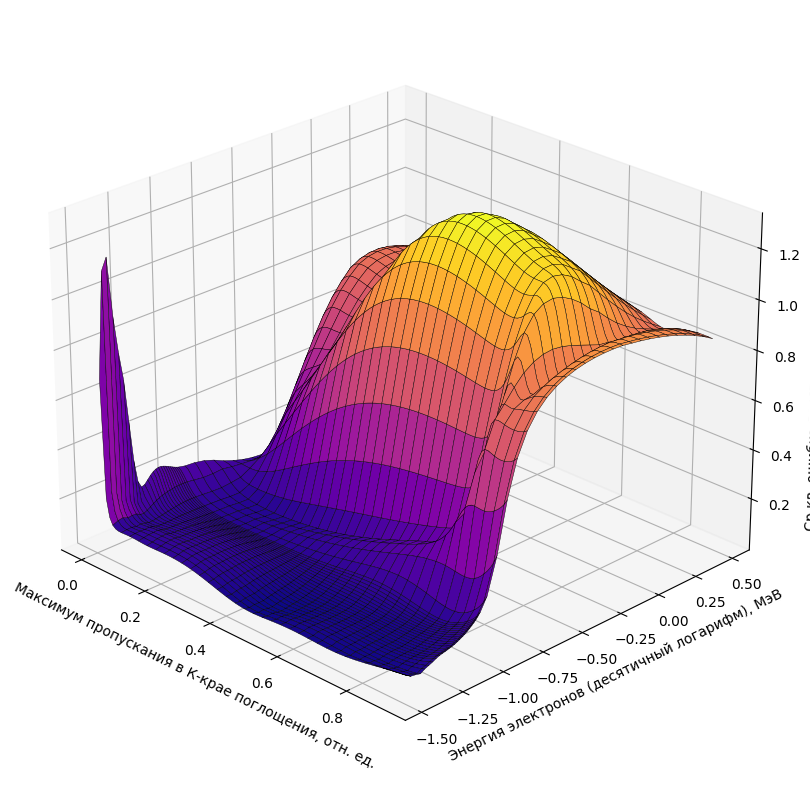

In [34]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': '3d'})
ax.plot_surface(X, Ylog, D, cmap='plasma', linewidth=0.3, edgecolors='k', shade=True)

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов (десятичный логарифм), МэВ')
ax.set_zlabel('Ср.кв. ошибка восстановления, отн. ед.')
fig.tight_layout()

# угол зрения (линейный)
# ax.view_init(elev=20, azim=-135)

# угол зрения (логарифм)
ax.view_init(elev=25, azim=-45)

# fig.savefig('К_фильтры_3D.jpg', bbox_inches='tight')

Контурная карта

In [35]:
linspace4 = np.geomspace(1e-2, 0.3, 20)
linspace5 = np.linspace(0.31, 1.4, 10)

In [36]:
c_map_levels = []
c_map_levels.extend(linspace4)
c_map_levels.extend(linspace5)

Text(0, 0.5, 'Энергия электронов, МэВ')

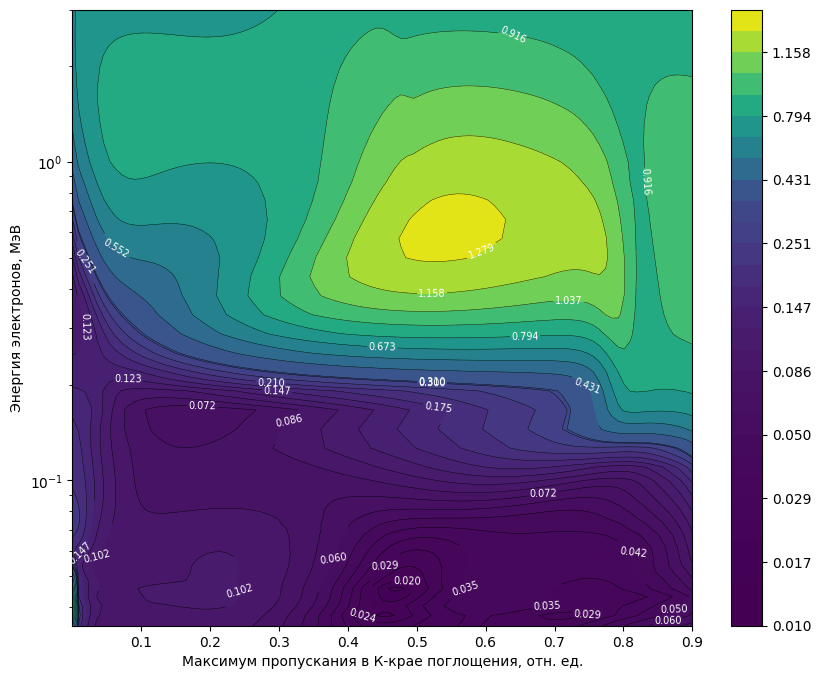

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))

c_map = ax.contourf(X, Y, D, levels=c_map_levels)
borders = ax.contour(X, Y, D, colors='k', levels=c_map_levels, linewidths=0.3)
ax.clabel(borders, fontsize=7, colors='w')
fig.colorbar(c_map)
ax.set_yscale('log')

ax.set_xlabel('Максимум пропускания в К-крае поглощения, отн. ед.')
ax.set_ylabel('Энергия электронов, МэВ')

# fig.savefig('К_фильтры_контурная_карта.jpg', bbox_inches='tight')

Зависимость минимальной ошибки восстановления от граничной энерии спектра

In [38]:
minimal_deviations = []

for i,val in enumerate(beams_energyes):
    min_value = min(DEV[i])
    minimal_deviations.append(min_value)

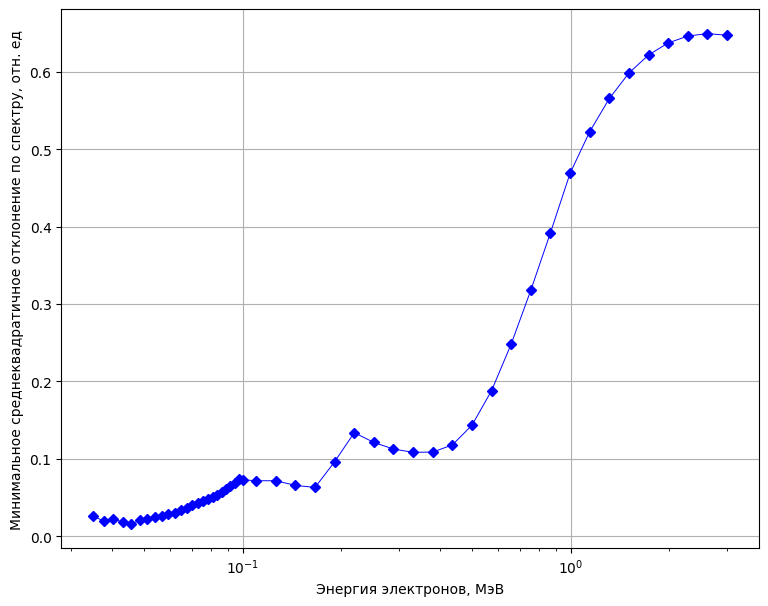

In [39]:
fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(beams_energyes, minimal_deviations, ls='-', marker='D', lw='0.7', ms=5, color='blue')

# настройки графика
ax.set_xlabel('Энергия электронов, МэВ', fontsize=10)
ax.set_ylabel('Минимальное среднеквадратичное отклонение по спектру, отн. ед', fontsize=10)
ax.tick_params(axis='both', labelsize=10)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.grid(True)

# fig.savefig('К_фильтры_минимум_ошибки_восстановления_от_энергии_электронов.jpg', bbox_inches='tight')

In [40]:
np.save(f'K_{m}_MIN.npy', minimal_deviations)